In [24]:
import os
import pandas as pd
import numpy as np
import pyreadr

import matplotlib.pyplot as plt
import seaborn as sns

# Set the working directory
path = "/home/sebastian/Documents/RA_Tasks/R_Scripts/translation_Stata_Code"
os.chdir(path)

In [2]:
def table(series):
    """
    Mimics the behavior of the R `table()` function.
    Takes a pandas Series as input and returns a frequency count of unique values.
    """
    # Convert the series to a pandas Series (if it isn't already)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    
    # Get the frequency count using value_counts()
    freq_table = series.value_counts(dropna=False).sort_index()
    
    # Return the result as a DataFrame for a similar output to R's table()
    return freq_table

In [3]:
# Read the .rds file
result = pyreadr.read_r("../generated_with_R/generated_labor.rds")
df_emp = result[None]  # Extract the DataFrame

# Check for missing values in the column 'pli0046'
print(df_emp['pli0046'].isna().sum())

# Display frequency table for the 'ill0' column
print(df_emp['ill0'].value_counts(dropna=False))



607249
ill0
 NaN    1079511
-5.0      40242
 2.0       7735
 1.0        452
-2.0        384
-1.0         42
Name: count, dtype: int64


In [4]:
# Step 1: Create the 'education' variable using numpy.select
conditions = [
    (df_emp['pgpsbil'] < 0) | (df_emp['pgpsbil'].isna()),
    (df_emp['pgpsbil'] == 3),
    (df_emp['pgpsbil'] == 4)
]
choices = [np.nan, 1, 1]
df_emp['education'] = np.select(conditions, choices, default=0)

# Step 2: Create the 'disord_ever' variable by grouping by 'pid' using transform and max
df_emp['disord_ever'] = df_emp.groupby('pid')['disord'].transform(
    lambda x: (x.isin([1, 2]).any()).astype(int)
)

# Step 3: Create the 'ill0_ever' variable by grouping by 'pid' using transform and max
df_emp['ill0_ever'] = df_emp.groupby('pid')['ill0'].transform(
    lambda x: (x.isin([1]).any()).astype(int)
)

In [5]:
# Define constants
MIN_YEAR = 1900
AGE_MIN = 18
AGE_MAX = 70

MIN_BIRTH_YEAR = 1950
MAX_BIRTH_YEAR = 1980

CARE_AGE_LOW = 0
CARE_AGE_HIGH = 100

In [6]:
# Filter data for non-females
df_sub = df_emp[
    (df_emp['female'] == 0) &
    (df_emp['age'] >= AGE_MIN) & (df_emp['age'] <= AGE_MAX) &
    (df_emp['syear'] >= MIN_YEAR) & (df_emp['syear'] < 2020) &
    (df_emp['gebjahr'] >= MIN_BIRTH_YEAR) & (df_emp['gebjahr'] <= MAX_BIRTH_YEAR)
]

# Filter data for females
df_fem = df_emp[
    (df_emp['female'] == 1) &
    (df_emp['age'] >= AGE_MIN) & (df_emp['age'] <= AGE_MAX) &
    (df_emp['syear'] >= MIN_YEAR) & (df_emp['syear'] < 2020) &
    (df_emp['gebjahr'] >= MIN_BIRTH_YEAR) & (df_emp['gebjahr'] <= MAX_BIRTH_YEAR)
]

In [7]:
df_fem.shape

(229374, 600)

In [8]:
# Step 1: Sort df_sub and df_fem by 'pid' and 'syear'
df_sub = df_sub.sort_values(by=['pid', 'syear'])
df_fem = df_fem.sort_values(by=['pid', 'syear'])

# Step 2: Create the 'care_parents' variable
df_fem['care_parents'] = np.where(
    (df_fem['care_at_all'] == 1) &
    # (df_fem['mother_alive'] == 1 | df_fem['father_alive'] == 1) & 
    # (df_sub['mother_lives_close'] == 1 | df_sub['father_lives_close'] == 1) &
    (df_fem['disord_ever'] != 1) &
    (df_fem['ill0_ever'] != 1) &
    (df_fem['partner_bad_health'] != 1),
    1, 0
)

# Step 3: Create the 'intensive_care_parents' variable
df_fem['intensive_care_parents'] = np.where(
    (df_fem['intensive_care'] == 1) &
    # (df_fem['mother_alive'] == 1 | df_fem['father_alive'] == 1) & 
    # (df_sub['mother_lives_close'] == 1 | df_sub['father_lives_close'] == 1) &
    (df_fem['disord_ever'] != 1) &
    (df_fem['ill0_ever'] != 1) &
    (df_fem['partner_bad_health'] != 1),
    1, 0
)

In [9]:
def compute_ever(series):
    """
    Determines the 'ever' status for a group.
    
    Parameters:
    series (pd.Series): A pandas Series representing a group of values.
    
    Returns:
    float: 1 if any value == 1, 0 if no value == 1 but at least one non-NaN exists, NaN otherwise.
    """
    if series.isna().all():
        return np.nan
    elif (series == 1).any():
        return 1
    else:
        return 0

In [10]:
# Calculate 'care_ever'
df_fem['care_ever'] = df_fem.groupby('pid')['care_at_all'].transform(compute_ever)

# Calculate 'intensive_care_ever'
df_fem['intensive_care_ever'] = df_fem.groupby('pid')['intensive_care'].transform(compute_ever)

# Calculate 'care_parents_ever'
df_fem['care_parents_ever'] = df_fem.groupby('pid')['care_at_all'].transform(compute_ever)

# Calculate 'intensive_care_parents_ever'
df_fem['intensive_care_parents_ever'] = df_fem.groupby('pid')['intensive_care'].transform(compute_ever)

In [11]:
# Display the distributions
print("care_ever distribution:")
print(table(df_fem['care_ever']))

print("\nintensive_care_ever distribution:")
print(table(df_fem['intensive_care_ever']))

print("\ncare_parents_ever distribution:")
print(table(df_fem['care_parents_ever']))

print("\nintensive_care_parents_ever distribution:")
print(table(df_fem['intensive_care_parents_ever']))

care_ever distribution:
care_ever
0.0    153455
1.0     53564
NaN     22355
Name: count, dtype: int64

intensive_care_ever distribution:
intensive_care_ever
0.0    175701
1.0     31318
NaN     22355
Name: count, dtype: int64

care_parents_ever distribution:
care_parents_ever
0.0    153455
1.0     53564
NaN     22355
Name: count, dtype: int64

intensive_care_parents_ever distribution:
intensive_care_parents_ever
0.0    175701
1.0     31318
NaN     22355
Name: count, dtype: int64


In [12]:
# Step 1: Calculate 'first_care' age for each 'pid'
df_fem['first_care'] = np.where(
    df_fem['care_at_all'] == 1, df_fem['age'], np.nan
)

# Step 2: Get the minimum 'age' for each 'pid' where 'care_at_all' == 1
df_fem['first_care'] = df_fem.groupby('pid')['first_care'].transform('min')

# Step 3: Convert 'first_care' to NaN if no care was provided by that individual
df_fem['first_care'] = df_fem['first_care'].where(df_fem['care_at_all'].groupby(df_fem['pid']).transform('max') == 1)

In [13]:
df_fem.shape # check

(229374, 607)

Mean first care age: 46.633933238742436
Standard deviation of first care age: 8.80086071463871


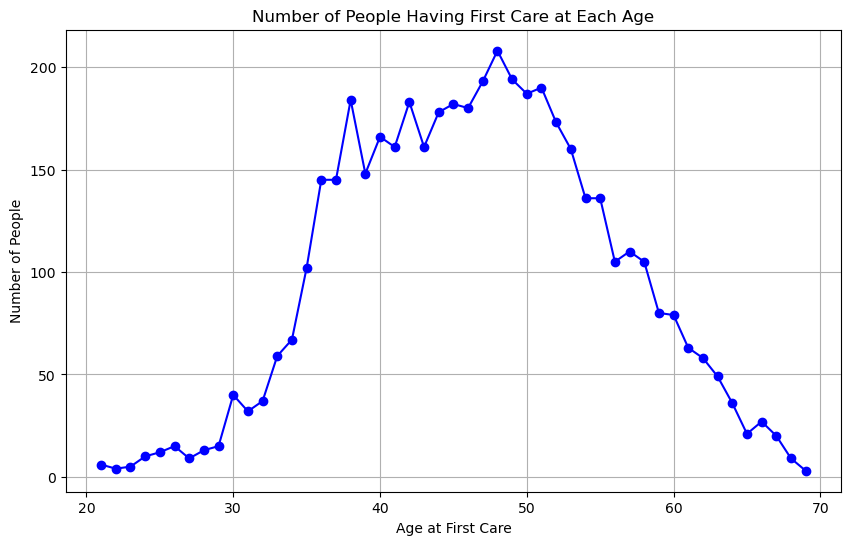

In [14]:
import matplotlib.pyplot as plt

# Calculate mean and standard deviation of 'first_care'
mean_first_care = df_fem['first_care'].mean(skipna=True)
std_first_care = df_fem['first_care'].std(skipna=True)
print(f"Mean first care age: {mean_first_care}")
print(f"Standard deviation of first care age: {std_first_care}")

# Step 2: Extract unique individuals with their 'first_care' age
first_care_ages = df_fem[['pid', 'first_care']].drop_duplicates().dropna(subset=['first_care'])

# Step 3: Count the number of people for each 'first_care' age
care_counts_by_age = first_care_ages['first_care'].value_counts().reset_index()
care_counts_by_age.columns = ['first_care', 'count']
care_counts_by_age = care_counts_by_age.sort_values(by='first_care')

# Step 4: Plot the counts by age using matplotlib
plt.figure(figsize=(10, 6))
plt.plot(care_counts_by_age['first_care'], care_counts_by_age['count'], color='blue', marker='o', linestyle='-')
plt.title("Number of People Having First Care at Each Age")
plt.xlabel("Age at First Care")
plt.ylabel("Number of People")
plt.grid(True)
plt.show()

In [15]:
table(df_fem['first_care'])

first_care
21.0        64
22.0        70
23.0        81
24.0       194
25.0       184
26.0       240
27.0       156
28.0       236
29.0       244
30.0       623
31.0       464
32.0       571
33.0       872
34.0       783
35.0       921
36.0      1583
37.0      1409
38.0      1669
39.0      1532
40.0      1612
41.0      1587
42.0      2075
43.0      1736
44.0      2260
45.0      2011
46.0      2011
47.0      2165
48.0      2585
49.0      2420
50.0      2464
51.0      2332
52.0      2418
53.0      2061
54.0      1833
55.0      1782
56.0      1223
57.0      1329
58.0      1187
59.0       816
60.0       852
61.0       737
62.0       678
63.0       385
64.0       369
65.0       217
66.0       318
67.0        91
68.0        74
69.0        40
NaN     175810
Name: count, dtype: int64

In [16]:
# Define age range constants
AGE_LOW = 44 - 18
AGE_HIGH = 46 - 18

# Step 1: Clean `df_fem` DataFrame
#df_fem = df_fem[
#    (df_fem['disord_ever'] != 1) &
#    (df_fem['ill0_ever'] != 1) &
#    ((df_fem['mother_alive'] == 1) | (df_fem['father_alive'] == 1)) &
#    (df_fem['partner_bad_health'] != 1)
#]

# Step 2: For women with `care_ever == 0` or `NaN`
# Adjusting the filtering condition to handle `NaN` properly
mean_pgexpft_age40_care0 = df_fem[
    ((df_fem['care_ever'] == 0) | (df_fem['care_ever'].isnull()) | (df_fem['care_ever'].isna())) & 
                                   #(df_fem['care_ever'].isnan())) &
    (df_fem['college'] == 0) &
    (df_fem['age'] >= AGE_LOW) & (df_fem['age'] <= AGE_HIGH)
].agg(
    mean_pgexpft=('pgexpft', 'mean'),
    se_pgexpft=('pgexpft', lambda x: x.std(ddof=0) / np.sqrt(x.count())),
    sample_size=('pgexpft', 'count')
)

# Step 3: For women with `intensive_care_parents_ever == 1`
mean_pgexpft_age40_intensive = df_fem[
    (df_fem['intensive_care_parents_ever'] == 1) &
    (df_fem['college'] == 0) &
    (df_fem['age'] >= AGE_LOW) & (df_fem['age'] <= AGE_HIGH)
].agg(
    mean_pgexpft=('pgexpft', 'mean'),
    se_pgexpft=('pgexpft', lambda x: x.std(ddof=0) / np.sqrt(x.count())),
    sample_size=('pgexpft', 'count')
)

print("Mean pgexpft for care_ever == 0:")
print(mean_pgexpft_age40_care0) # wrong number of sample size

print("\nMean pgexpft for intensive_care_parents_ever == 1:")
print(mean_pgexpft_age40_intensive)

Mean pgexpft for care_ever == 0:
                  pgexpft
mean_pgexpft     3.936589
se_pgexpft       0.038898
sample_size   5705.000000

Mean pgexpft for intensive_care_parents_ever == 1:
                 pgexpft
mean_pgexpft    3.746051
se_pgexpft      0.135147
sample_size   487.000000


In [17]:
# Step 4: For women with `care_ever == 0`
# Compute average of `pgexppt` at age 40
mean_pgexppt_age40_care0 = df_fem[
    (df_fem['care_ever'] == 0) &
    (df_fem['college'] == 0) &
    (df_fem['age'] >= AGE_LOW) & (df_fem['age'] <= AGE_HIGH)
].agg(
    mean_pgexppt=('pgexppt', 'mean'),
    se_pgexppt=('pgexppt', lambda x: x.std(ddof=0) / np.sqrt(x.count())),
    sample_size=('pgexppt', 'count')
)

# Step 5: For women with `intensive_care_parents_ever == 1`
# Compute average of `pgexppt` at age 40
mean_pgexppt_age40_intensive = df_fem[
    (df_fem['intensive_care_parents_ever'] == 1) &
    (df_fem['college'] == 0) &
    (df_fem['age'] >= AGE_LOW) & (df_fem['age'] <= AGE_HIGH)
].agg(
    mean_pgexppt=('pgexppt', 'mean'),
    se_pgexppt=('pgexppt', lambda x: x.std(ddof=0) / np.sqrt(x.count())),
    sample_size=('pgexppt', 'count')
)

print("\nMean pgexppt for care_ever == 0:")
print(mean_pgexppt_age40_care0) # wrong :(

print("\nMean pgexppt for intensive_care_parents_ever == 1:")
print(mean_pgexppt_age40_intensive)


Mean pgexppt for care_ever == 0:
                  pgexppt
mean_pgexppt     0.791263
se_pgexppt       0.021875
sample_size   4774.000000

Mean pgexppt for intensive_care_parents_ever == 1:
                 pgexppt
mean_pgexppt    0.914801
se_pgexppt      0.069484
sample_size   487.000000


## 7

In [26]:
CARE_AGE_LOW = 40

In [66]:
# Step 1: Get list of `pid`s to drop based on condition
pids_to_drop = df_fem[
    (df_fem['care_parents'] == True) & (df_fem['age'] < CARE_AGE_LOW)
]['pid'].unique()

# Step 2: Filter the DataFrame for `intensive_care_parents_ever == 1` and exclude `pid`s in `pids_to_drop`
df_fem_care_50_60 = df_fem[
    (df_fem['intensive_care_parents_ever'] == 1) #& (~df_fem['pid'].isin(pids_to_drop))
]

# Step 3: Generate frequency tables similar to R's `table()`

# Frequency table for ages in `df_fem`
age_table = df_fem['age'].value_counts().sort_index()
print("Age distribution in df_fem:")
print(age_table)

# Frequency table for ages in `df_fem_care_50_60`
age_table_care_50_60 = df_fem_care_50_60['age'].value_counts().sort_index()
print("\nAge distribution in df_fem_care_50_60:")
print(age_table_care_50_60)

# Frequency table for `care_ever`
care_ever_table = df_fem['care_ever'].value_counts(dropna=False).sort_index()
print("\nCare ever distribution in df_fem:")
print(care_ever_table)

# Calculate the percentage of individuals with `care_ever == 1`
care_ever_percentage = (care_ever_table.get(1, 0) / care_ever_table.sum()) * 100
print(f"\nPercentage of individuals who ever provided care: {care_ever_percentage:.2f}%")

# Frequency table for `intensive_care_ever`
intensive_care_table = df_fem['intensive_care_ever'].value_counts(dropna=False).sort_index()
print("\nIntensive care ever distribution in df_fem:")
print(intensive_care_table)

# Calculate the percentage of individuals with `intensive_care_ever == 1`
intensive_care_percentage = (intensive_care_table.get(1, 0) / intensive_care_table.sum()) * 100
print(f"\nPercentage of individuals who ever provided intensive care: {intensive_care_percentage:.2f}%")


Age distribution in df_fem:
age
18.0    1027
19.0    1186
20.0    1444
21.0    1689
22.0    1916
23.0    2172
24.0    2405
25.0    2633
26.0    2907
27.0    3133
28.0    3326
29.0    3561
30.0    4055
31.0    4549
32.0    5031
33.0    5610
34.0    6119
35.0    6711
36.0    7322
37.0    7859
38.0    8477
39.0    8888
40.0    8797
41.0    8785
42.0    8508
43.0    8406
44.0    8135
45.0    7903
46.0    7661
47.0    7362
48.0    7022
49.0    6660
50.0    6416
51.0    6021
52.0    5515
53.0    5037
54.0    4573
55.0    4151
56.0    3826
57.0    3471
58.0    3128
59.0    2809
60.0    2506
61.0    2243
62.0    1949
63.0    1653
64.0    1396
65.0    1125
66.0     923
67.0     699
68.0     460
69.0     214
Name: count, dtype: int64

Age distribution in df_fem_care_50_60:
age
18.0      42
19.0      51
20.0      61
21.0      78
22.0      97
23.0     107
24.0     127
25.0     141
26.0     168
27.0     197
28.0     219
29.0     254
30.0     315
31.0     369
32.0     416
33.0     498
34.0     576
3

In [67]:
df_fem.shape

(229374, 608)

In [68]:
import pandas as pd

# Add a gender variable to each DataFrame
df_sub['gender'] = "Male"
df_fem['gender'] = "Female"

# Step 1: Calculate the yearly mean for full-time employment for males
yearly_mean_male = df_sub.groupby('age').agg(
    mean_full_time=('current_full_time', lambda x: x.mean(skipna=True))
).reset_index()

# Step 2: Calculate the yearly mean for full-time employment for females with specific conditions
yearly_mean_female = df_fem[
    (df_fem['care_ever'] == 0) &
    (df_fem['disord_ever'] != 1) &
    (df_fem['ill0_ever'] != 1) &
    (df_fem['partner_bad_health'] != 1)
].groupby('age').agg(
    mean_full_time=('current_full_time', lambda x: x.mean(skipna=True))
).reset_index()

# Step 3: Calculate the yearly mean for part-time employment for females
yearly_mean_female_part_time = df_fem[
    df_fem['care_ever'] == 0
].groupby('age').agg(
    mean_full_time=('current_part_time', lambda x: x.mean(skipna=True))
).reset_index()

# Step 4: Calculate the yearly mean for females not employed
yearly_mean_female_not_employed = df_fem[
    df_fem['care_ever'] == 0
].groupby('age').agg(
    mean_full_time=('current_not_employed', lambda x: x.mean(skipna=True))
).reset_index()

# Step 5: Calculate the yearly mean for full-time employment for females aged 50-60 who provided care
yearly_mean_female_50_60 = df_fem_care_50_60.groupby('age').agg(
    mean_full_time=('current_full_time', lambda x: x.mean(skipna=True))
).reset_index()

In [69]:
# Display the results
print("Yearly mean full-time employment for males:")
print(yearly_mean_male)

print("\nYearly mean full-time employment for females:")
print(yearly_mean_female)

print("\nYearly mean part-time employment for females:")
print(yearly_mean_female_part_time)

print("\nYearly mean not employed for females:")
print(yearly_mean_female_not_employed)

print("\nYearly mean full-time employment for females aged 50-60:")
print(yearly_mean_female_50_60)


Yearly mean full-time employment for males:
     age  mean_full_time
0   18.0        0.040773
1   19.0        0.201581
2   20.0        0.357713
3   21.0        0.453321
4   22.0        0.497741
5   23.0        0.574372
6   24.0        0.600910
7   25.0        0.658671
8   26.0        0.673422
9   27.0        0.727980
10  28.0        0.772795
11  29.0        0.813451
12  30.0        0.833977
13  31.0        0.842590
14  32.0        0.864051
15  33.0        0.862130
16  34.0        0.869879
17  35.0        0.870793
18  36.0        0.859582
19  37.0        0.849269
20  38.0        0.846448
21  39.0        0.841052
22  40.0        0.842593
23  41.0        0.844108
24  42.0        0.841553
25  43.0        0.842565
26  44.0        0.846668
27  45.0        0.847502
28  46.0        0.844177
29  47.0        0.834283
30  48.0        0.832858
31  49.0        0.821702
32  50.0        0.817462
33  51.0        0.820716
34  52.0        0.808305
35  53.0        0.796838
36  54.0        0.782821
37  55

In [70]:
yearly_mean_female_50_60

,age,mean_full_time
0,18.0,0.137931
1,19.0,0.214286
2,20.0,0.219512
3,21.0,0.400000
4,22.0,0.397436
5,23.0,0.465909
6,24.0,0.440367
7,25.0,0.417910
8,26.0,0.403846
9,27.0,0.371585


In [71]:
# ------------------------------
# Step 1: Add a New Column to Distinguish the Datasets
# ------------------------------

# Add a 'category' column to distinguish between the datasets
yearly_mean_female['category'] = "All Ages"
yearly_mean_female_50_60['category'] = "Ages 50-60"

# ------------------------------
# Step 2: Combine the Datasets
# ------------------------------

# Combine the two DataFrames vertically (similar to R's rbind)
combined_data = pd.concat([yearly_mean_female_50_60, yearly_mean_female], ignore_index=True)

In [72]:
# Define the "All Ages" group by applying multiple filters
df_fem_all_ages = df_fem.loc[
    (df_fem['care_ever'] == 0) &
    (df_fem['disord_ever'] != 1) &
    (df_fem['ill0_ever'] != 1) &
    (df_fem['partner_bad_health'] != 1)
].copy()

In [73]:
# Group by 'age' and compute summary statistics
summary_all_ages = df_fem_all_ages.groupby('age').agg(
    mean_full_time=('current_full_time', 'mean'),
    std_full_time=('current_full_time', 'std'),
    count=('current_full_time', 'count')
).reset_index()

# Calculate Standard Error (SE)
summary_all_ages['se'] = summary_all_ages['std_full_time'] / np.sqrt(summary_all_ages['count'])

# Calculate 95% Confidence Interval (CI)
confidence_level = 0.95
z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)  # ≈1.96 for 95% CI

summary_all_ages['ci_lower'] = summary_all_ages['mean_full_time'] - z_score * summary_all_ages['se']
summary_all_ages['ci_upper'] = summary_all_ages['mean_full_time'] + z_score * summary_all_ages['se']

# Clip the CI bounds to [0,1]
summary_all_ages['ci_lower'] = summary_all_ages['ci_lower'].clip(lower=0)
summary_all_ages['ci_upper'] = summary_all_ages['ci_upper'].clip(upper=1)

# Add 'category' column
summary_all_ages['category'] = 'All Ages'

In [74]:
summary_all_ages

,age,mean_full_time,std_full_time,count,se,ci_lower,ci_upper,category
0,18.0,0.028302,0.166095,318,0.009314,0.010046,0.046557,All Ages
1,19.0,0.104348,0.306155,345,0.016483,0.072042,0.136654,All Ages
2,20.0,0.285714,0.452216,490,0.020429,0.245674,0.325754,All Ages
3,21.0,0.399413,0.490138,681,0.018782,0.362600,0.436225,All Ages
4,22.0,0.420207,0.493876,871,0.016734,0.387408,0.453005,All Ages
5,23.0,0.488889,0.500099,1125,0.014910,0.459666,0.518112,All Ages
6,24.0,0.474171,0.499525,1297,0.013870,0.446986,0.501357,All Ages
7,25.0,0.477151,0.499646,1488,0.012953,0.451764,0.502537,All Ages
8,26.0,0.468124,0.499134,1647,0.012299,0.444018,0.492230,All Ages
9,27.0,0.468663,0.499155,1803,0.011755,0.445623,0.491704,All Ages


In [75]:
# Group by 'age' and compute summary statistics
summary_50_60 = df_fem_care_50_60.groupby('age').agg(
    mean_full_time=('current_full_time', 'mean'),
    std_full_time=('current_full_time', 'std'),
    count=('current_full_time', 'count')
).reset_index()

# Calculate Standard Error (SE)
summary_50_60['se'] = summary_50_60['std_full_time'] / np.sqrt(summary_50_60['count'])

# Calculate 95% Confidence Interval (CI)
summary_50_60['ci_lower'] = summary_50_60['mean_full_time'] - z_score * summary_50_60['se']
summary_50_60['ci_upper'] = summary_50_60['mean_full_time'] + z_score * summary_50_60['se']

# Clip the CI bounds to [0,1]
summary_50_60['ci_lower'] = summary_50_60['ci_lower'].clip(lower=0)
summary_50_60['ci_upper'] = summary_50_60['ci_upper'].clip(upper=1)

# Add 'category' column
summary_50_60['category'] = 'Ages 50-60'

In [76]:
summary_50_60

,age,mean_full_time,std_full_time,count,se,ci_lower,ci_upper,category
0,18.0,0.137931,0.350931,29,0.065166,0.010207,0.265655,Ages 50-60
1,19.0,0.214286,0.417855,28,0.078967,0.059513,0.369059,Ages 50-60
2,20.0,0.219512,0.419058,41,0.065446,0.091241,0.347784,Ages 50-60
3,21.0,0.400000,0.494032,60,0.063779,0.274995,0.525005,Ages 50-60
4,22.0,0.397436,0.492535,78,0.055769,0.288131,0.506740,Ages 50-60
5,23.0,0.465909,0.501695,88,0.053481,0.361088,0.570730,Ages 50-60
6,24.0,0.440367,0.498724,109,0.047769,0.346741,0.533993,Ages 50-60
7,25.0,0.417910,0.495066,134,0.042767,0.334088,0.501733,Ages 50-60
8,26.0,0.403846,0.492248,156,0.039411,0.326601,0.481091,Ages 50-60
9,27.0,0.371585,0.484554,183,0.035819,0.301380,0.441789,Ages 50-60


In [77]:
summary_combined = pd.concat([summary_all_ages, summary_50_60], ignore_index=True)

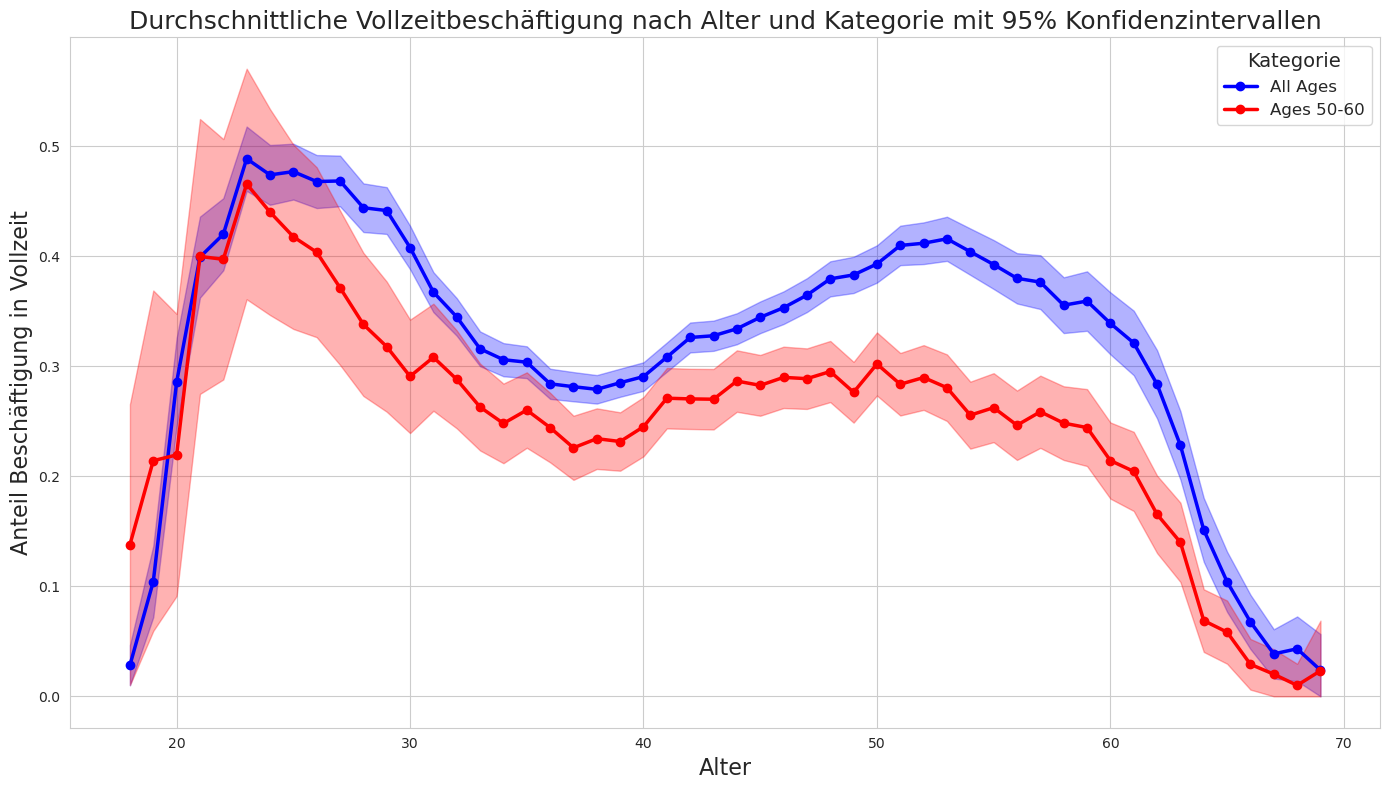

In [78]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(14, 8))

# Define color palette
palette = {'All Ages': 'blue', 'Ages 50-60': 'red'}

# Plot each category separately to handle coloring and CIs
for category in summary_combined['category'].unique():
    subset = summary_combined[summary_combined['category'] == category]
    
    # Ensure there are non-NaN values to plot
    subset = subset.dropna(subset=['mean_full_time', 'ci_lower', 'ci_upper'])
    
    # Sort by age to ensure lines are plotted correctly
    subset = subset.sort_values('age')
    
    # Plot the mean_full_time line
    plt.plot(
        subset['age'],
        subset['mean_full_time'],
        label=category,
        color=palette[category],
        linewidth=2.5,
        marker='o'
    )
    
    # Add the confidence interval using fill_between
    plt.fill_between(
        subset['age'],
        subset['ci_lower'],
        subset['ci_upper'],
        color=palette[category],
        alpha=0.3
    )

# Add labels to the axes
plt.xlabel("Alter", fontsize=16)  # "Age" in German
plt.ylabel("Anteil Beschäftigung in Vollzeit", fontsize=16)  # "Percentage of Full-time Employment" in German

# Customize the legend
plt.legend(title='Kategorie', fontsize=12, title_fontsize=14)

# Add a title to the plot
plt.title("Durchschnittliche Vollzeitbeschäftigung nach Alter und Kategorie mit 95% Konfidenzintervallen", fontsize=18)

# Improve layout spacing
plt.tight_layout()

# Display the plot
plt.show()


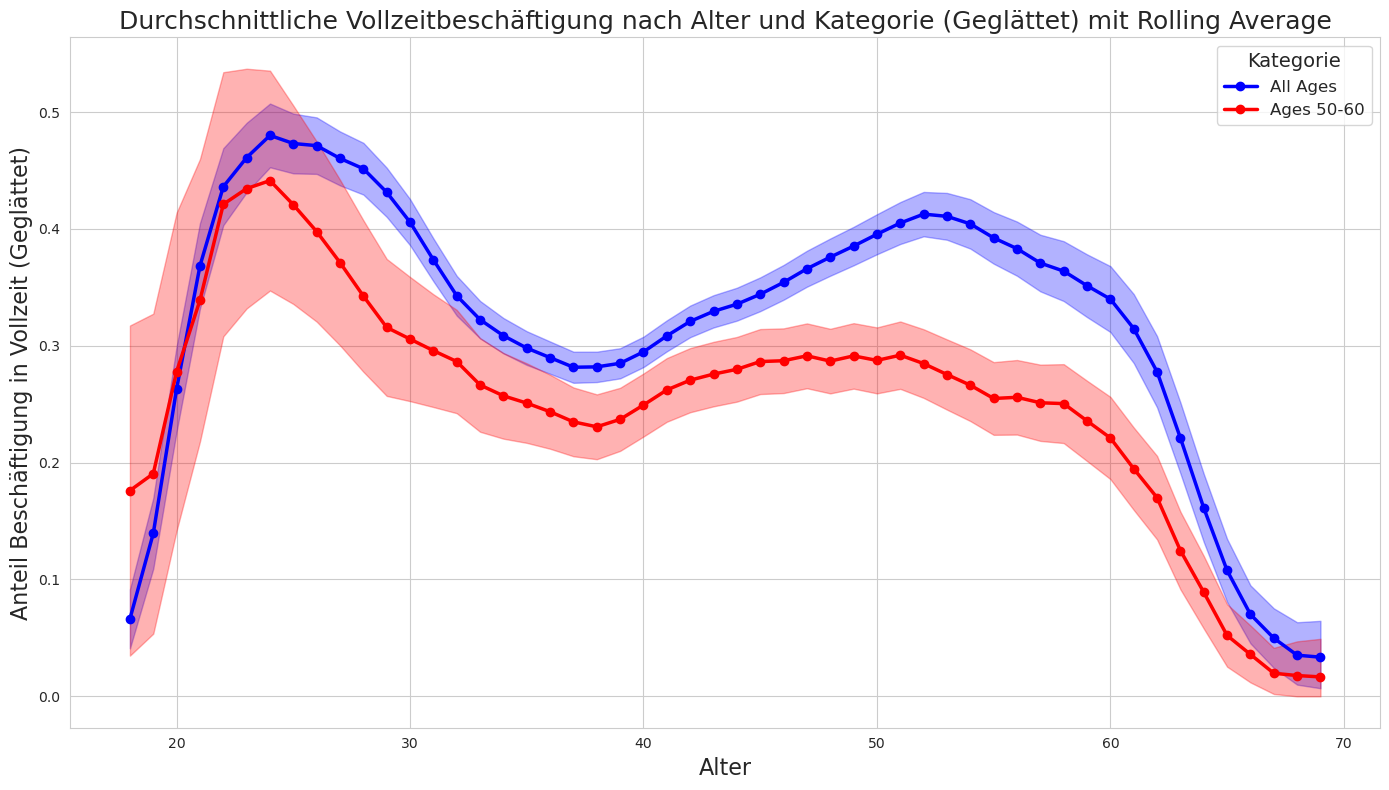

In [79]:
# ------------------------------
# Step 5: Implement Rolling Averages
# ------------------------------

# Define the window size for Rolling Average (e.g., 3)
window_size = 3

# Initialize columns for smoothed values
summary_combined['mean_full_time_smoothed'] = np.nan
summary_combined['ci_lower_smoothed'] = np.nan
summary_combined['ci_upper_smoothed'] = np.nan

# Apply Rolling Average for each category
for category in summary_combined['category'].unique():
    subset = summary_combined[summary_combined['category'] == category].sort_values('age')
    
    # Apply rolling mean with window size, center=True for centered window
    summary_combined.loc[summary_combined['category'] == category, 'mean_full_time_smoothed'] = subset['mean_full_time'].rolling(
        window=window_size, min_periods=1, center=True).mean()
    
    summary_combined.loc[summary_combined['category'] == category, 'ci_lower_smoothed'] = subset['ci_lower'].rolling(
        window=window_size, min_periods=1, center=True).mean()
    
    summary_combined.loc[summary_combined['category'] == category, 'ci_upper_smoothed'] = subset['ci_upper'].rolling(
        window=window_size, min_periods=1, center=True).mean()

# ------------------------------
# Step 6: Plot Rolling Average Smoothed Data
# ------------------------------

# Initialize the plot
plt.figure(figsize=(14, 8))

# Define color palette
palette = {'All Ages': 'blue', 'Ages 50-60': 'red'}

# Plot each category with Rolling Average
for category in summary_combined['category'].unique():
    subset = summary_combined[summary_combined['category'] == category].sort_values('age')
    
    # Drop NaN values in smoothed columns
    subset = subset.dropna(subset=['mean_full_time_smoothed', 'ci_lower_smoothed', 'ci_upper_smoothed'])
    
    # Plot the smoothed mean
    plt.plot(
        subset['age'],
        subset['mean_full_time_smoothed'],
        label=category,
        color=palette[category],
        linewidth=2.5,
        marker='o'
    )
    
    # Plot the smoothed confidence intervals
    plt.fill_between(
        subset['age'],
        subset['ci_lower_smoothed'],
        subset['ci_upper_smoothed'],
        color=palette[category],
        alpha=0.3
    )

# Add labels and title
plt.xlabel("Alter", fontsize=16)
plt.ylabel("Anteil Beschäftigung in Vollzeit (Geglättet)", fontsize=16)
plt.title("Durchschnittliche Vollzeitbeschäftigung nach Alter und Kategorie (Geglättet) mit Rolling Average", fontsize=18)
plt.legend(title='Kategorie', fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()

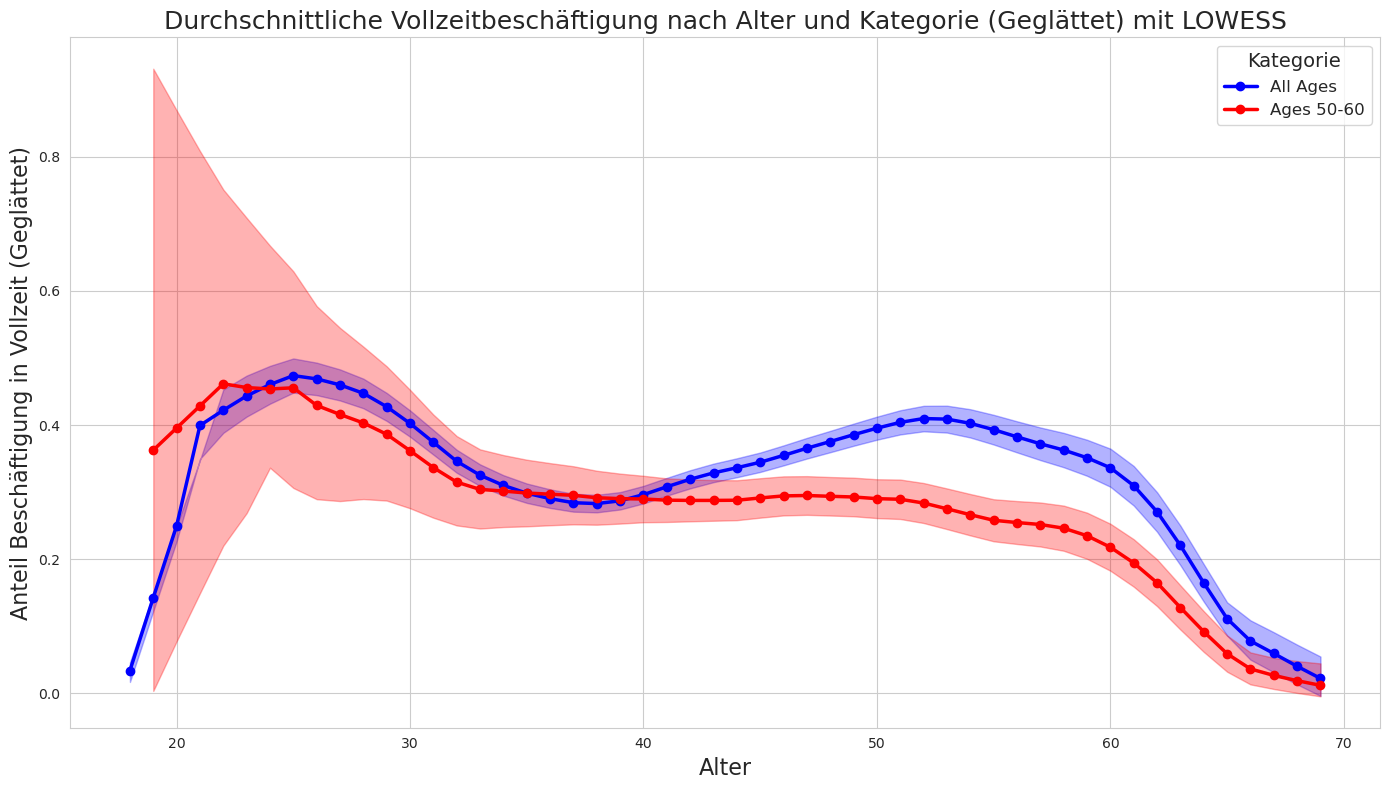

In [65]:
# ------------------------------
# Step 6: Implement LOWESS Smoothing
# ------------------------------

# Initialize columns for LOWESS smoothed values
summary_combined['mean_full_time_lowess'] = np.nan
summary_combined['ci_lower_lowess'] = np.nan
summary_combined['ci_upper_lowess'] = np.nan

# Define the frac parameter for LOWESS (controls the degree of smoothing)
frac = 0.15  # Adjust between 0 < frac <= 1 based on your data

# Apply LOWESS for each category
for category in summary_combined['category'].unique():
    subset = summary_combined[summary_combined['category'] == category].sort_values('age')
    
    # Perform LOWESS smoothing on mean_full_time
    lowess_mean = lowess(endog=subset['mean_full_time'],
                         exog=subset['age'],
                         frac=frac,
                         return_sorted=False)
    
    # Perform LOWESS smoothing on ci_lower and ci_upper
    lowess_ci_lower = lowess(endog=subset['ci_lower'],
                             exog=subset['age'],
                             frac=frac,
                             return_sorted=False)
    
    lowess_ci_upper = lowess(endog=subset['ci_upper'],
                             exog=subset['age'],
                             frac=frac,
                             return_sorted=False)
    
    # Assign the smoothed values
    summary_combined.loc[summary_combined['category'] == category, 'mean_full_time_lowess'] = lowess_mean
    summary_combined.loc[summary_combined['category'] == category, 'ci_lower_lowess'] = lowess_ci_lower
    summary_combined.loc[summary_combined['category'] == category, 'ci_upper_lowess'] = lowess_ci_upper

# ------------------------------
# Step 7: Plot LOWESS Smoothed Data
# ------------------------------

# Initialize the plot
plt.figure(figsize=(14, 8))

# Define color palette
palette = {'All Ages': 'blue', 'Ages 50-60': 'red'}

# Plot each category with LOWESS smoothing
for category in summary_combined['category'].unique():
    subset = summary_combined[summary_combined['category'] == category].sort_values('age')
    
    # Drop NaN values in smoothed columns
    subset = subset.dropna(subset=['mean_full_time_lowess', 'ci_lower_lowess', 'ci_upper_lowess'])
    
    # Plot the LOWESS smoothed mean
    plt.plot(
        subset['age'],
        subset['mean_full_time_lowess'],
        label=category,
        color=palette[category],
        linewidth=2.5,
        marker='o'
    )
    
    # Plot the LOWESS smoothed confidence intervals
    plt.fill_between(
        subset['age'],
        subset['ci_lower_lowess'],
        subset['ci_upper_lowess'],
        color=palette[category],
        alpha=0.3
    )

# Add labels and title
plt.xlabel("Alter", fontsize=16)
plt.ylabel("Anteil Beschäftigung in Vollzeit (Geglättet)", fontsize=16)
plt.title("Durchschnittliche Vollzeitbeschäftigung nach Alter und Kategorie (Geglättet) mit LOWESS", fontsize=18)
plt.legend(title='Kategorie', fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()

In [52]:
summary_stats

,age,category,mean_full_time,std_full_time,count,se,ci_lower,ci_upper
0,18.0,Ages 50-60,0.000000,NaN,1,NaN,NaN,NaN
1,18.0,All Ages,0.028302,NaN,1,NaN,NaN,NaN
2,19.0,Ages 50-60,0.500000,NaN,1,NaN,NaN,NaN
3,19.0,All Ages,0.104348,NaN,1,NaN,NaN,NaN
4,20.0,Ages 50-60,0.500000,NaN,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
99,67.0,All Ages,0.038596,NaN,1,NaN,NaN,NaN
100,68.0,Ages 50-60,0.010000,NaN,1,NaN,NaN,NaN
101,68.0,All Ages,0.043243,NaN,1,NaN,NaN,NaN
102,69.0,Ages 50-60,0.023256,NaN,1,NaN,NaN,NaN


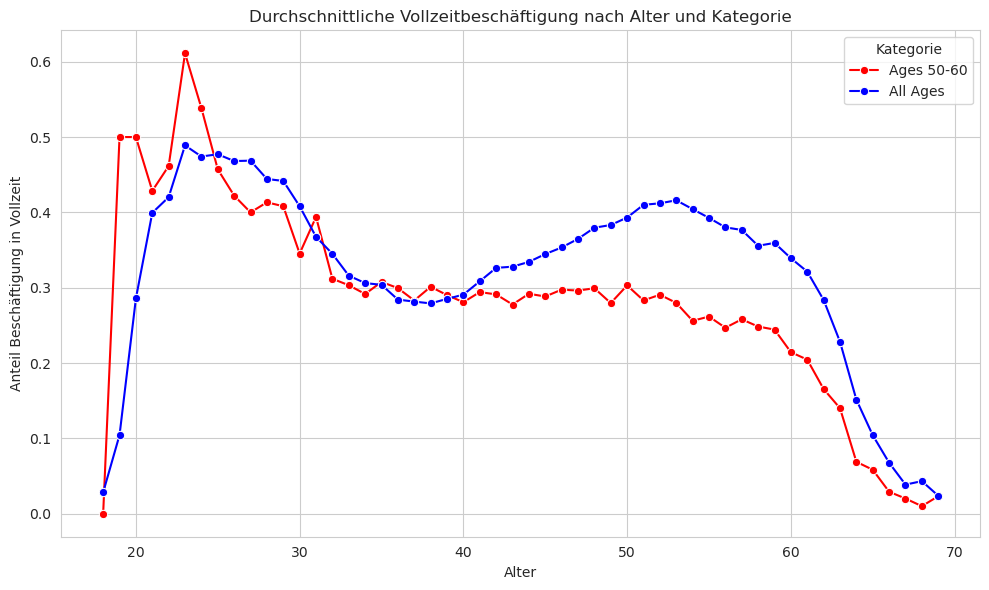

In [35]:
# ------------------------------
# Step 3: Plot the Data
# ------------------------------

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(10, 6))

# Create the line plot using seaborn
sns.lineplot(
    data=combined_data,
    x='age',
    y='mean_full_time',
    hue='category',
    palette={'All Ages': 'blue', 'Ages 50-60': 'red'},
    marker='o'  # Adds markers to the lines for better visibility
)

# Add labels to the axes
plt.xlabel("Alter")  # "Age" in German
plt.ylabel("Anteil Beschäftigung in Vollzeit")  # "Percentage of Full-time Employment" in German

# Customize the legend
plt.legend(title='Kategorie')  # "Category" in German

# Apply a minimal theme (already set by sns.set_style)
# If further customization is needed, additional seaborn/matplotlib functions can be used

# Display the plot
plt.title("Durchschnittliche Vollzeitbeschäftigung nach Alter und Kategorie")  # Optional: Add a title
plt.tight_layout()  # Adjust the padding between and around subplots
plt.show()

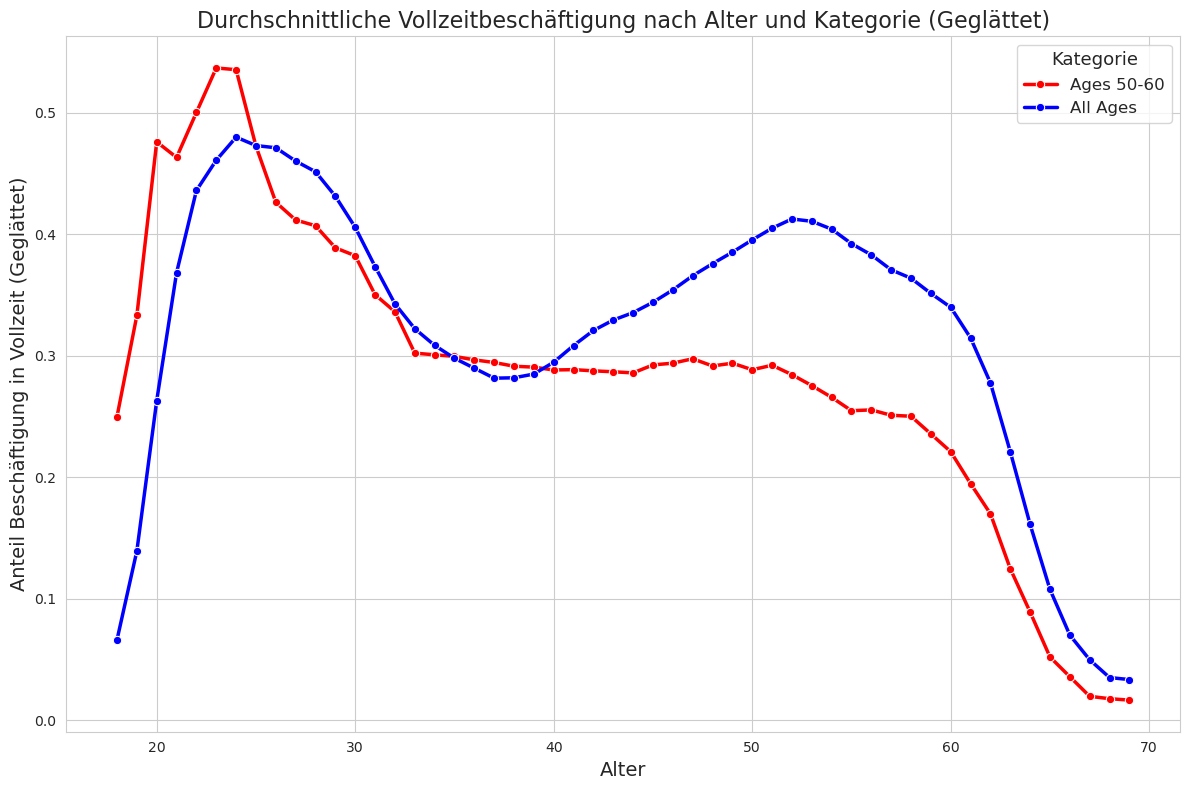

In [47]:
# ------------------------------
# Step 3: Apply Rolling Average for Smoothing
# ------------------------------

# Define the window size for rolling average (e.g., 3 years)
window_size = 3

# Sort the data by category and age to ensure correct rolling
combined_data = combined_data.sort_values(by=['category', 'age'])

# Apply rolling average within each category
combined_data['mean_full_time_smoothed'] = combined_data.groupby('category')['mean_full_time'].transform(
    lambda x: x.rolling(window=window_size, min_periods=1, center=True).mean()
)

# ------------------------------
# Step 4: Plot the Smoothed Data
# ------------------------------

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(12, 8))

# Create the line plot using seaborn with smoothed data
sns.lineplot(
    data=combined_data,
    x='age',
    y='mean_full_time_smoothed',
    hue='category',
    palette={'All Ages': 'blue', 'Ages 50-60': 'red'},
    marker='o',  # Adds markers to the lines for better visibility
    linewidth=2.5  # Thicker lines for better visibility
)

# Add labels to the axes
plt.xlabel("Alter", fontsize=14)  # "Age" in German
plt.ylabel("Anteil Beschäftigung in Vollzeit (Geglättet)", fontsize=14)  # "Percentage of Full-time Employment (Smoothed)" in German

# Customize the legend
plt.legend(title='Kategorie', fontsize=12, title_fontsize=13)

# Add a title to the plot
plt.title("Durchschnittliche Vollzeitbeschäftigung nach Alter und Kategorie (Geglättet)", fontsize=16)  # "Average Full-time Employment by Age and Category (Smoothed)"

# Improve layout spacing
plt.tight_layout()

# Display the plot
plt.show()

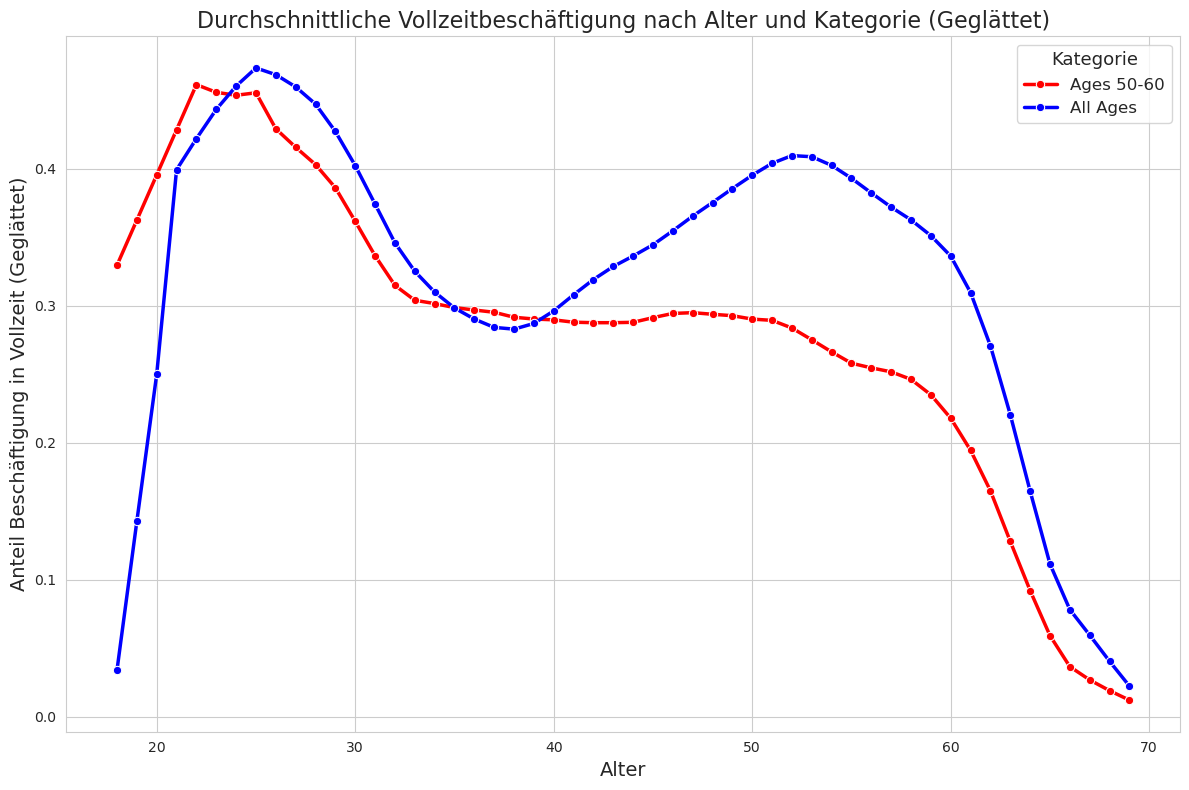

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# ------------------------------
# Step 1: Add a New Column to Distinguish the Datasets
# ------------------------------

# Add a 'category' column to distinguish between the datasets
yearly_mean_female['category'] = "All Ages"
yearly_mean_female_50_60['category'] = "Ages 50-60"

# ------------------------------
# Step 2: Combine the Datasets
# ------------------------------

# Combine the two DataFrames vertically (similar to R's rbind)
combined_data = pd.concat([yearly_mean_female_50_60, yearly_mean_female], ignore_index=True)

# ------------------------------
# Step 3: Apply LOWESS for Smoothing
# ------------------------------

# Sort the data by category and age to ensure correct LOWESS application
combined_data = combined_data.sort_values(by=['category', 'age'])

# Initialize a DataFrame to hold smoothed data
smoothed_data = pd.DataFrame()

# Apply LOWESS smoothing for each category
for category in combined_data['category'].unique():
    subset = combined_data[combined_data['category'] == category]
    # Perform LOWESS smoothing
    lowess_result = lowess(endog=subset['mean_full_time'], exog=subset['age'], frac=0.15)
    # Create a DataFrame from the LOWESS result
    lowess_df = pd.DataFrame(lowess_result, columns=['age', 'mean_full_time_smoothed'])
    lowess_df['category'] = category
    smoothed_data = pd.concat([smoothed_data, lowess_df], ignore_index=True)

# ------------------------------
# Step 4: Plot the Smoothed Data
# ------------------------------

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(12, 8))

# Create the line plot using seaborn with smoothed data
sns.lineplot(
    data=smoothed_data,
    x='age',
    y='mean_full_time_smoothed',
    hue='category',
    palette={'All Ages': 'blue', 'Ages 50-60': 'red'},
    marker='o',  # Adds markers to the lines for better visibility
    linewidth=2.5  # Thicker lines for better visibility
)

# Add labels to the axes
plt.xlabel("Alter", fontsize=14)  # "Age" in German
plt.ylabel("Anteil Beschäftigung in Vollzeit (Geglättet)", fontsize=14)  # "Percentage of Full-time Employment (Smoothed)" in German

# Customize the legend
plt.legend(title='Kategorie', fontsize=12, title_fontsize=13)

# Add a title to the plot
plt.title("Durchschnittliche Vollzeitbeschäftigung nach Alter und Kategorie (Geglättet)", fontsize=16)  # "Average Full-time Employment by Age and Category (Smoothed)"

# Improve layout spacing
plt.tight_layout()

# Display the plot
plt.show()

/home/sebastian/miniconda3/envs/caregiving/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sebastian/miniconda3/envs/caregiving/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/sebastian/miniconda3/envs/caregiving/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sebastian/miniconda3/envs/caregiving/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


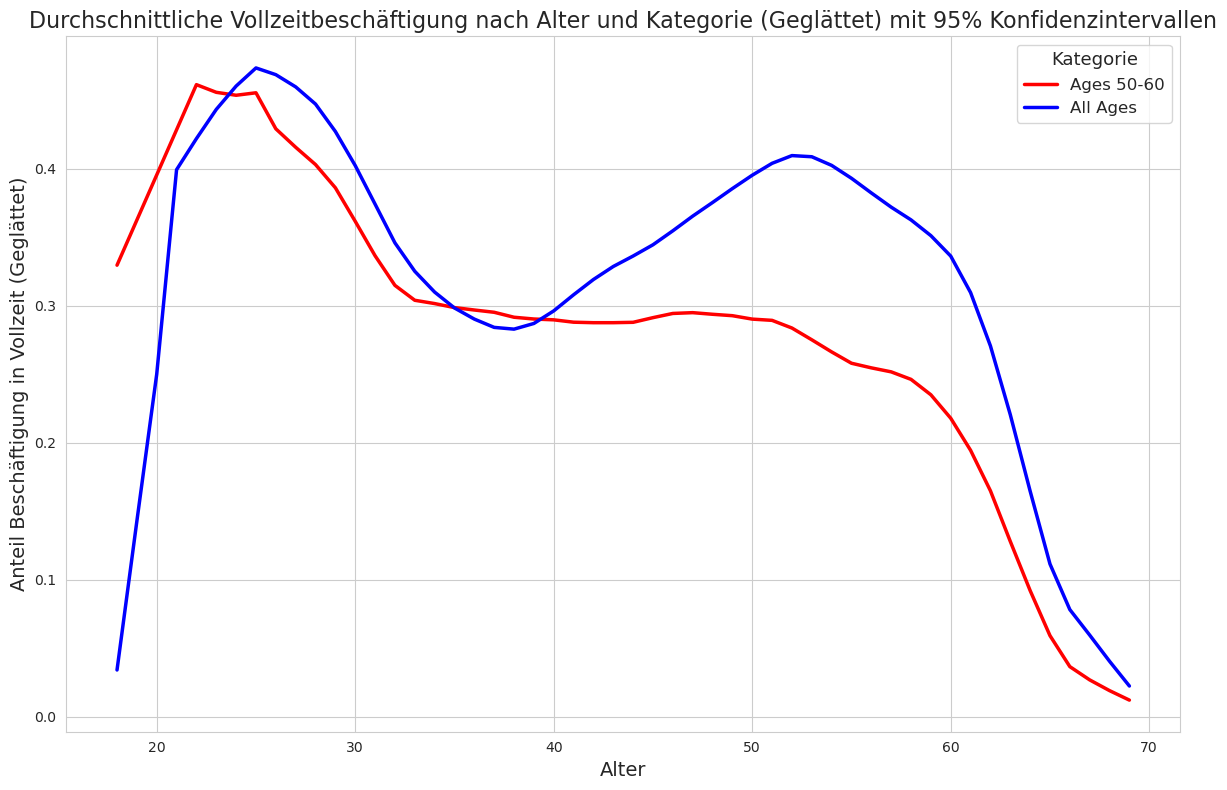

## Compare part time full time experience